In [1]:
import numpy as np
import pandas as pd
import seaborn as sns 

import intervaltree
import matplotlib.pyplot as plt 
from matplotlib.ticker import MultipleLocator

## Load data

In [79]:
# joanito_nanomnt = pd.read_csv('/node200data/18parkky/datasets/data/public/processed_data/Immunotherapy_CRC_Chen_et_al/NanoMnT.AlleleTable.tsv.gz', sep='\t')
# joanito_nanomnt = pd.read_csv('/node200data/18parkky/datasets/data/public/processed_data/Joanito_et_al/NanoMnT.AlleleTable.tsv.gz', sep='\t')
# joanito_nanomnt = pd.read_csv('/node200data/18parkky/datasets/data/public/processed_data/Kinker_et_al/AlleleTable.merged.preprocessed.tsv.gz', sep='\t')
joanito_nanomnt = pd.read_csv('/node200data/18parkky/datasets/data/public/processed_data/Joanito_et_al/SG-BULK/AlleleTable.concat.processed.tsv.gz', sep='\t')

In [80]:
gff = pd.read_csv('/node200data/18parkky/datasets/reference/transcriptome/GFF/gencode.v47.basic.annotation.labeled.gtf', sep='\t')
gff['chrom'] = gff['chr']
# gff = gff[gff['feature']=='gene']
gff = gff[gff['feature']=='exon']

In [85]:
joanito_nanomnt['chrom'] = [ locus.split(':')[0] for locus in joanito_nanomnt.locus ]
joanito_nanomnt['start'] = [ int(locus.split(':')[1].split('-')[0]) for locus in joanito_nanomnt.locus ]
joanito_nanomnt['end'] = [ int(locus.split(':')[1].split('-')[1]) for locus in joanito_nanomnt.locus ]
joanito_nanomnt.head(2)

,read_name,locus,repeat_unit,allele,reference_STR_allele,left_flanking_seq,right_flanking_seq,flag,CB,UMI,corrected_allele,editing_distance,read_STR_allele,MSI_status,PatientID,flanking_quality,diff,chrom,start,end
0,E00415:59:H525YALXX:6:1207:7151:48300,chr11:100688130-100688141,T,TTTTTTTTTTTTT,12,CTTTAA,AATTTA,0,NaN,NaN,TTTTTTTTTTTTT,0,13,MSI,1253,Good,1,chr11,100688130,100688141
1,E00415:59:H525YALXX:6:1207:7628:48775,chr11:100688130-100688141,T,TTTTTTTTTTTTT,12,CTTTAA,AATTTA,0,NaN,NaN,TTTTTTTTTTTTT,0,13,MSI,1253,Good,1,chr11,100688130,100688141


## Distribution of reads that mapped to microsatellite-encoding genes

In [109]:
gff[['gene_name']].dropna()

,gene_name
2,DDX11L16
3,DDX11L16
4,DDX11L16
5,DDX11L16
8,DDX11L1
...,...
2225561,MT-ND6
2225566,MT-TE
2225569,MT-CYB
2225574,MT-TT


In [82]:
tree = intervaltree.IntervalTree()
dict_chrom_to_tree = dict()

for chrom, edf in gff.groupby('chrom'):
    dict_chrom_to_tree[chrom] = intervaltree.IntervalTree()
    
    for tup in edf.itertuples():
        dict_chrom_to_tree[chrom][tup.start:tup.end+1] = tup.gene_name

In [83]:
joanito_nanomnt['chrom'] = [ f'chr{chrom}' for chrom in joanito_nanomnt['chrom'] ] # only for Chen et al and Kinker et al

In [86]:
joanito_nanomnt.head(2)

,read_name,locus,repeat_unit,allele,reference_STR_allele,left_flanking_seq,right_flanking_seq,flag,CB,UMI,corrected_allele,editing_distance,read_STR_allele,MSI_status,PatientID,flanking_quality,diff,chrom,start,end
0,E00415:59:H525YALXX:6:1207:7151:48300,chr11:100688130-100688141,T,TTTTTTTTTTTTT,12,CTTTAA,AATTTA,0,NaN,NaN,TTTTTTTTTTTTT,0,13,MSI,1253,Good,1,chr11,100688130,100688141
1,E00415:59:H525YALXX:6:1207:7628:48775,chr11:100688130-100688141,T,TTTTTTTTTTTTT,12,CTTTAA,AATTTA,0,NaN,NaN,TTTTTTTTTTTTT,0,13,MSI,1253,Good,1,chr11,100688130,100688141


In [87]:
dict_gene_to_count = dict()
intergenic_reads = list()

dict_readname_to_gene   = dict()

for chrom, edf in joanito_nanomnt.groupby('chrom'):
    for tup in edf.itertuples():
        
        try:
            genes = set([ entry[2] for entry in list(dict_chrom_to_tree[chrom][tup.start:tup.end]) ])
        except (TypeError, IndexError):
            genes = None 
        
        if genes == None or len(genes)==0:
            intergenic_reads.append( tup.read_name )
            dict_readname_to_gene[tup.read_name] = 'intergenic'
            continue 
        
        else:
            if len(genes)==1:
                dict_readname_to_gene[tup.read_name] = list(genes)[0]
                try:
                    dict_gene_to_count[list(genes)[0]] += 1
                except KeyError: dict_gene_to_count[list(genes)[0]] = 1
            else:
                dict_readname_to_gene[tup.read_name] = ','.join(sorted(genes))
                try: dict_gene_to_count[','.join(sorted(genes))] += 1
                except KeyError: dict_gene_to_count[','.join(sorted(genes))] = 1

In [88]:
joanito_nanomnt['gene']     = [ dict_readname_to_gene[rn] for rn in joanito_nanomnt['read_name'] ]
joanito_nanomnt['n_gene']   = [ len(dict_readname_to_gene[rn].split(',')) for rn in joanito_nanomnt['read_name'] ]

In [114]:
# joanito_nanomnt.to_csv('/node200data/18parkky/datasets/data/public/processed_data/Joanito_et_al/NanoMnT.AlleleTable.gene_labeled.tsv.gz', 
#                        sep='\t', index=False, compression='gzip')

joanito_nanomnt.to_csv('/node200data/18parkky/datasets/data/public/processed_data/Joanito_et_al/SG-BULK/AlleleTable.concat.processed.gene_labeled.tsv.gz', 
                       sep='\t', index=False, compression='gzip')

In [115]:
dict_gene_to_count = dict(sorted(dict_gene_to_count.items(), key=lambda x:x[1], reverse=True))

In [116]:
MS_gene_info = pd.DataFrame.from_dict(dict_gene_to_count, orient='index')
MS_gene_info.columns = ['read_count']
MS_gene_info.reset_index(inplace=True)
MS_gene_info.sort_values('read_count', ascending=False, inplace=True )
MS_gene_info.reset_index(inplace=True, drop=True)
MS_gene_info.reset_index(inplace=True)
MS_gene_info.columns = ['rank', 'gene', 'read_count']
MS_gene_info = MS_gene_info[(MS_gene_info['read_count']>=1)]

In [117]:
MS_gene_info['log_read_count'] = [np.log(rc) for rc in MS_gene_info['read_count']]
MS_gene_info.head(20)

,rank,gene,read_count,log_read_count
0,0,"MALAT1,TALAM1",292454,12.586063
1,1,NEAT1,86739,11.370659
2,2,PIGR,63109,11.052619
3,3,"LRRC75A,SNHG29",24418,10.103076
4,4,CCND2,20853,9.945253
5,5,LGALS3,19182,9.861728
6,6,SPTBN1,15553,9.652009
7,7,"ACTN4,CAPN12",15420,9.643421
8,8,SLC12A2,15374,9.640433
9,9,"ENSG00000257764,LYZ",15008,9.616339


In [265]:
# MS_gene_info.to_csv('/node200data/18parkky/datasets/data/public/processed_data/Immunotherapy_CRC_Chen_et_al/NanoMnT_alignedGeneInfo.tsv', sep='\t', index=False)
# MS_gene_info.to_csv('/node200data/18parkky/datasets/data/public/processed_data/Joanito_et_al/NanoMnT_alignedGeneInfo.tsv', sep='\t', index=False)
MS_gene_info.to_csv('/node200data/18parkky/datasets/data/public/processed_data/Kinker_et_al/NanoMnT_alignedGeneInfo.tsv', sep='\t', index=False)

## Visualize MS-encoding gene counts

In [266]:
# # Joanito - lightseagreen, Chen - mediumpurple, Kinker - goldenrod
joanito_ms_gene_counts = pd.read_csv('/node200data/18parkky/datasets/data/public/processed_data/Joanito_et_al/NanoMnT_alignedGeneInfo.tsv', sep='\t')
kinker_ms_gene_counts = pd.read_csv('/node200data/18parkky/datasets/data/public/processed_data/Kinker_et_al/NanoMnT_alignedGeneInfo.tsv', sep='\t')
chen_ms_gene_counts = pd.read_csv('/node200data/18parkky/datasets/data/public/processed_data/Immunotherapy_CRC_Chen_et_al/NanoMnT_alignedGeneInfo.tsv', sep='\t')

In [267]:
chen_ms_gene_counts.sort_values('read_count', ascending=False).head(8)

,rank,gene,read_count,log_read_count
0,0,JCHAIN,334212,12.719531
1,1,"MALAT1,TALAM1",258933,12.464325
2,2,PTMA,151986,11.931544
3,3,ACTB,126008,11.744101
4,4,MATR3,84822,11.348310
5,5,NEAT1,84423,11.343595
6,6,CCNI,77975,11.264144
7,7,"ENSG00000298468,ING1",60312,11.007286


In [268]:
joanito_ms_gene_counts['log_read_count'] = [ np.log10(rc) for rc in joanito_ms_gene_counts['read_count'] ]
kinker_ms_gene_counts['log_read_count'] = [ np.log10(rc) for rc in kinker_ms_gene_counts['read_count'] ]
chen_ms_gene_counts['log_read_count'] = [ np.log10(rc) for rc in chen_ms_gene_counts['read_count'] ]

In [269]:
joanito_total_ms_read_counts = sum(joanito_ms_gene_counts['read_count'])
joanito_ms_gene_counts['percentage'] = [ 100*rc/joanito_total_ms_read_counts for rc in joanito_ms_gene_counts['read_count'] ]

kinker_total_ms_read_counts = sum(kinker_ms_gene_counts['read_count'])
kinker_ms_gene_counts['percentage'] = [ 100*rc/kinker_total_ms_read_counts for rc in kinker_ms_gene_counts['read_count'] ]

chen_total_ms_read_counts = sum(chen_ms_gene_counts['read_count'])
chen_ms_gene_counts['percentage'] = [ 100*rc/chen_total_ms_read_counts for rc in chen_ms_gene_counts['read_count'] ]

In [271]:
chen_ms_gene_counts[chen_ms_gene_counts['gene']=='MALAT1,TALAM1']

,rank,gene,read_count,log_read_count,percentage
1,1,"MALAT1,TALAM1",258933,5.413187,4.408906


/tmp/ipykernel_714/3582563455.py:2: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  ax = sns.scatterplot(data=joanito_ms_gene_counts.sort_values('read_count', ascending=False).iloc[0:50],


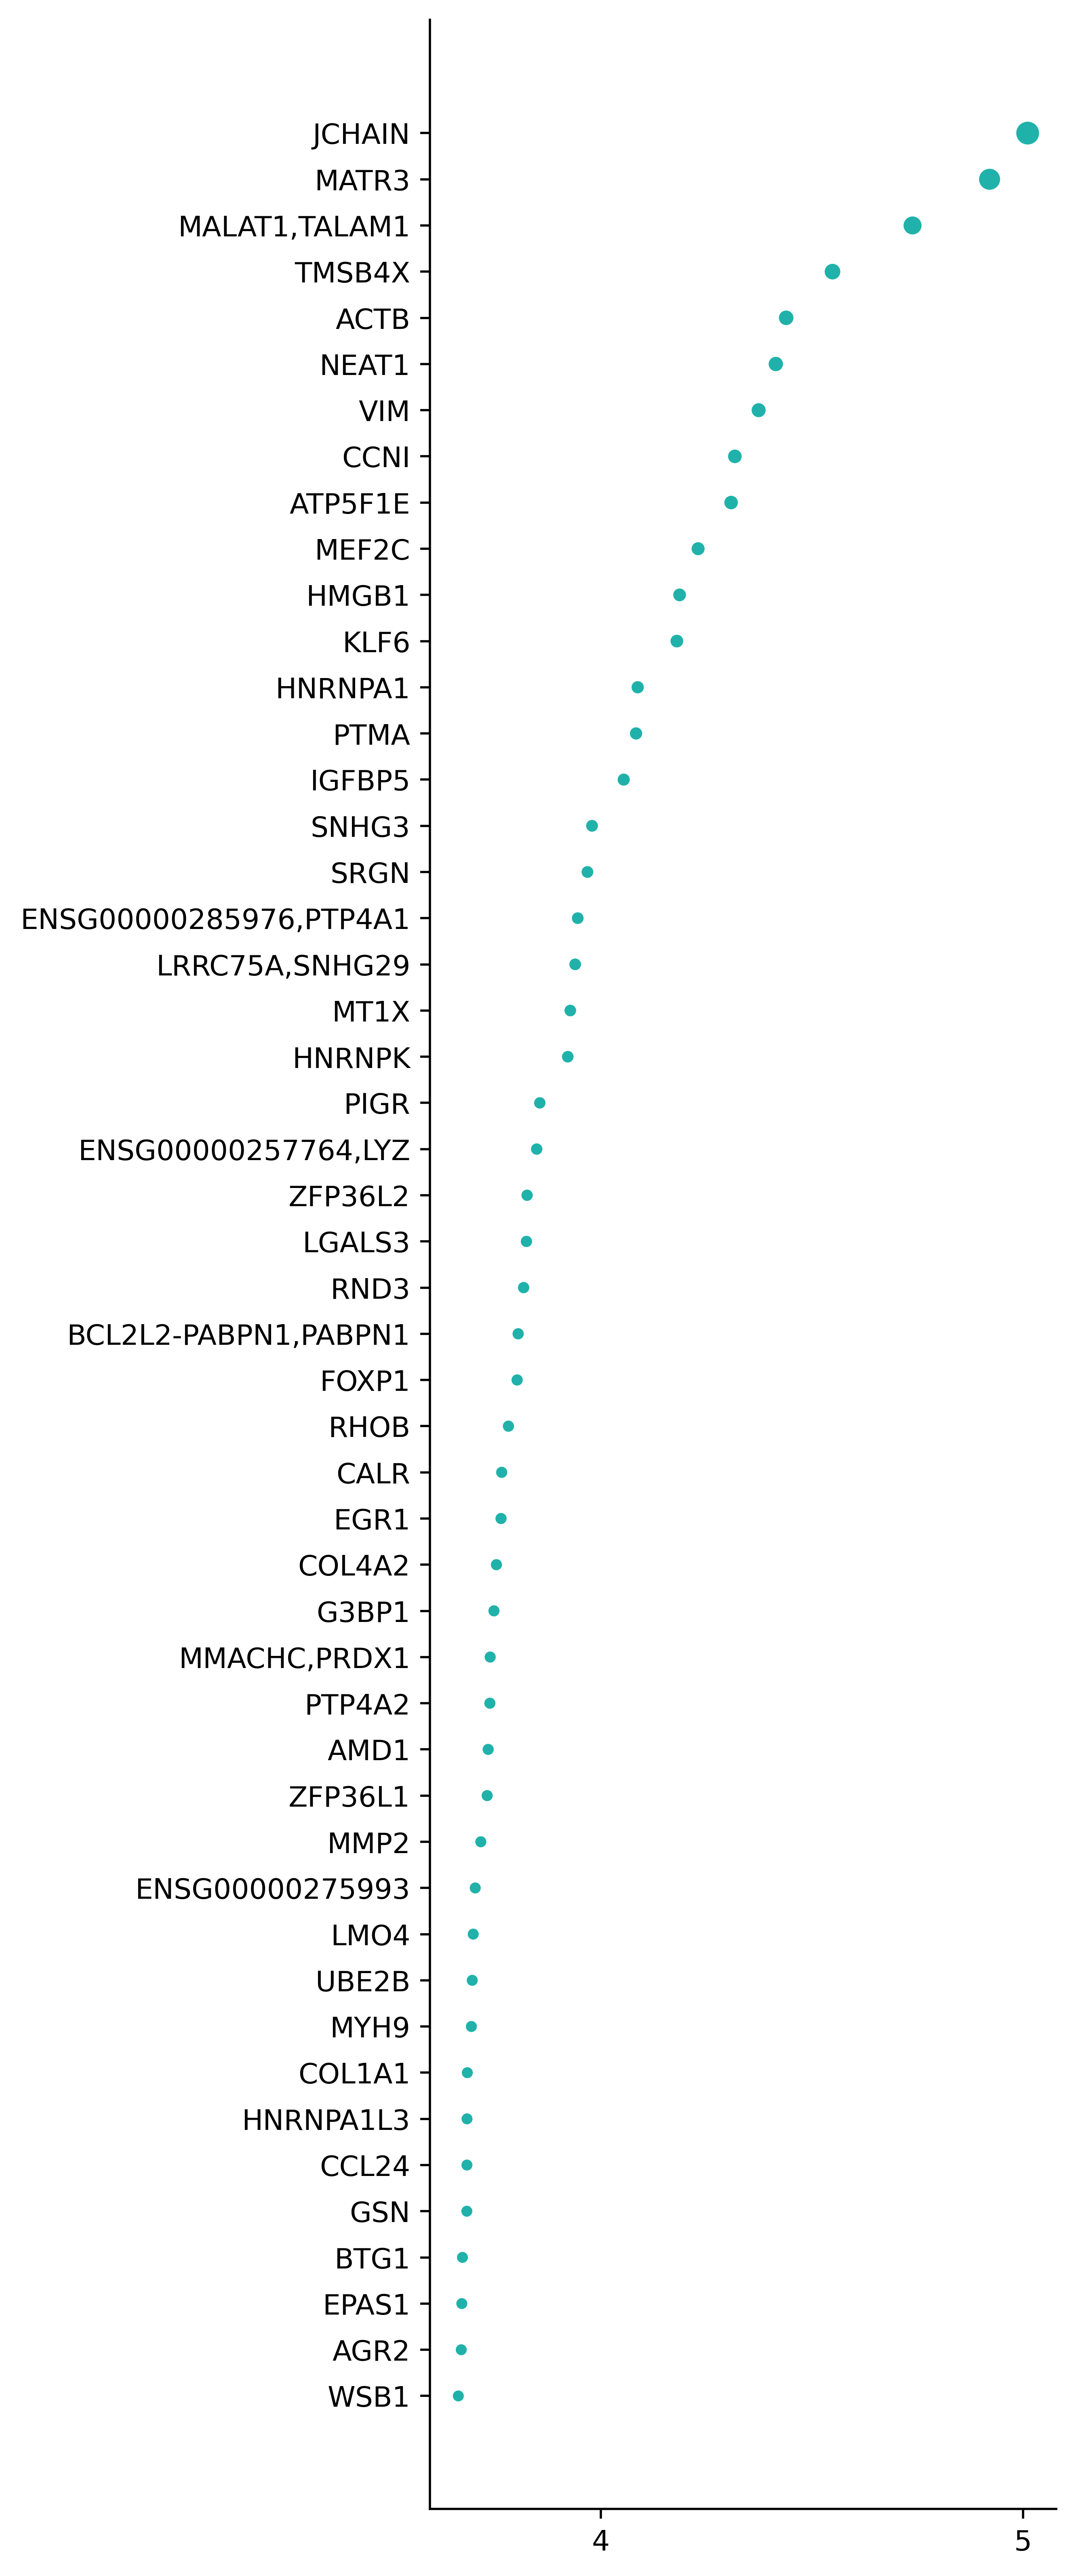

In [274]:
plt.figure(figsize=(4, 16), dpi=500)
ax = sns.scatterplot(data=joanito_ms_gene_counts.sort_values('read_count', ascending=False).iloc[0:50], 
                     y='gene', x='log_read_count', size="percentage", 
                     palette=sns.dark_palette("seagreen", as_cmap=True),
                     color='lightseagreen',
                     legend=False,
                     ) # mediumpurple lightseagreen goldenrod
# sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1), title='',)
ax.set_xlabel('');
ax.set_ylabel('');
ax.xaxis.set_major_locator(MultipleLocator(1));
# ax.set_xticklabels([]);
# ax.set_xticks([]);
sns.despine()

In [275]:
joanito_gene_set = set(joanito_ms_gene_counts['gene'])
kinker_gene_set = set(kinker_ms_gene_counts['gene'])
chen_gene_set = set(chen_ms_gene_counts['gene'])

union_genes = joanito_gene_set.union(kinker_gene_set).union(chen_gene_set)
len(union_genes)

17897

In [276]:
dict_gene_to_counts = { gene : [0, 0, 0] for gene in union_genes }

for tup in joanito_ms_gene_counts.itertuples():
    dict_gene_to_counts[tup.gene][0] = tup.read_count
    
for tup in kinker_ms_gene_counts.itertuples():
    dict_gene_to_counts[tup.gene][1] = tup.read_count

for tup in chen_ms_gene_counts.itertuples():
    dict_gene_to_counts[tup.gene][2] = tup.read_count

GeneCountsAcrossDatasets = pd.DataFrame(dict_gene_to_counts).T
GeneCountsAcrossDatasets.reset_index(inplace=True)
GeneCountsAcrossDatasets.columns = ['gene', 'Joanito', 'Kinker', 'Chen']
GeneCountsAcrossDatasets = GeneCountsAcrossDatasets[['gene', 'Joanito', 'Chen']]
GeneCountsAcrossDatasets = GeneCountsAcrossDatasets[(GeneCountsAcrossDatasets['Joanito']>1) & (GeneCountsAcrossDatasets['Chen']>1)]
GeneCountsAcrossDatasets['Joanito'] = [ np.log(rc) for rc in GeneCountsAcrossDatasets['Joanito'] ]
GeneCountsAcrossDatasets['Chen'] = [ np.log(rc) for rc in GeneCountsAcrossDatasets['Chen'] ]
GeneCountsAcrossDatasets.sort_values('Joanito')

,gene,Joanito,Chen
1390,BMS1,0.693147,2.708050
1399,ENSG00000286355,0.693147,0.693147
1407,"ENSG00000255102,ENSG00000255516",0.693147,0.693147
1412,ENSG00000228408,0.693147,1.609438
16358,KIZ-AS1,0.693147,3.526361
...,...,...,...
10479,ACTB,10.220850,11.744101
769,TMSB4X,10.473591,9.602788
8273,"MALAT1,TALAM1",10.910277,12.464325
9452,MATR3,11.330516,11.348310


In [295]:
import scipy.stats 

r, pval = scipy.stats.pearsonr(GeneCountsAcrossDatasets['Joanito'], GeneCountsAcrossDatasets['Chen'])
print(round(r, 4), round(pval, 4))

0.8245 0.0


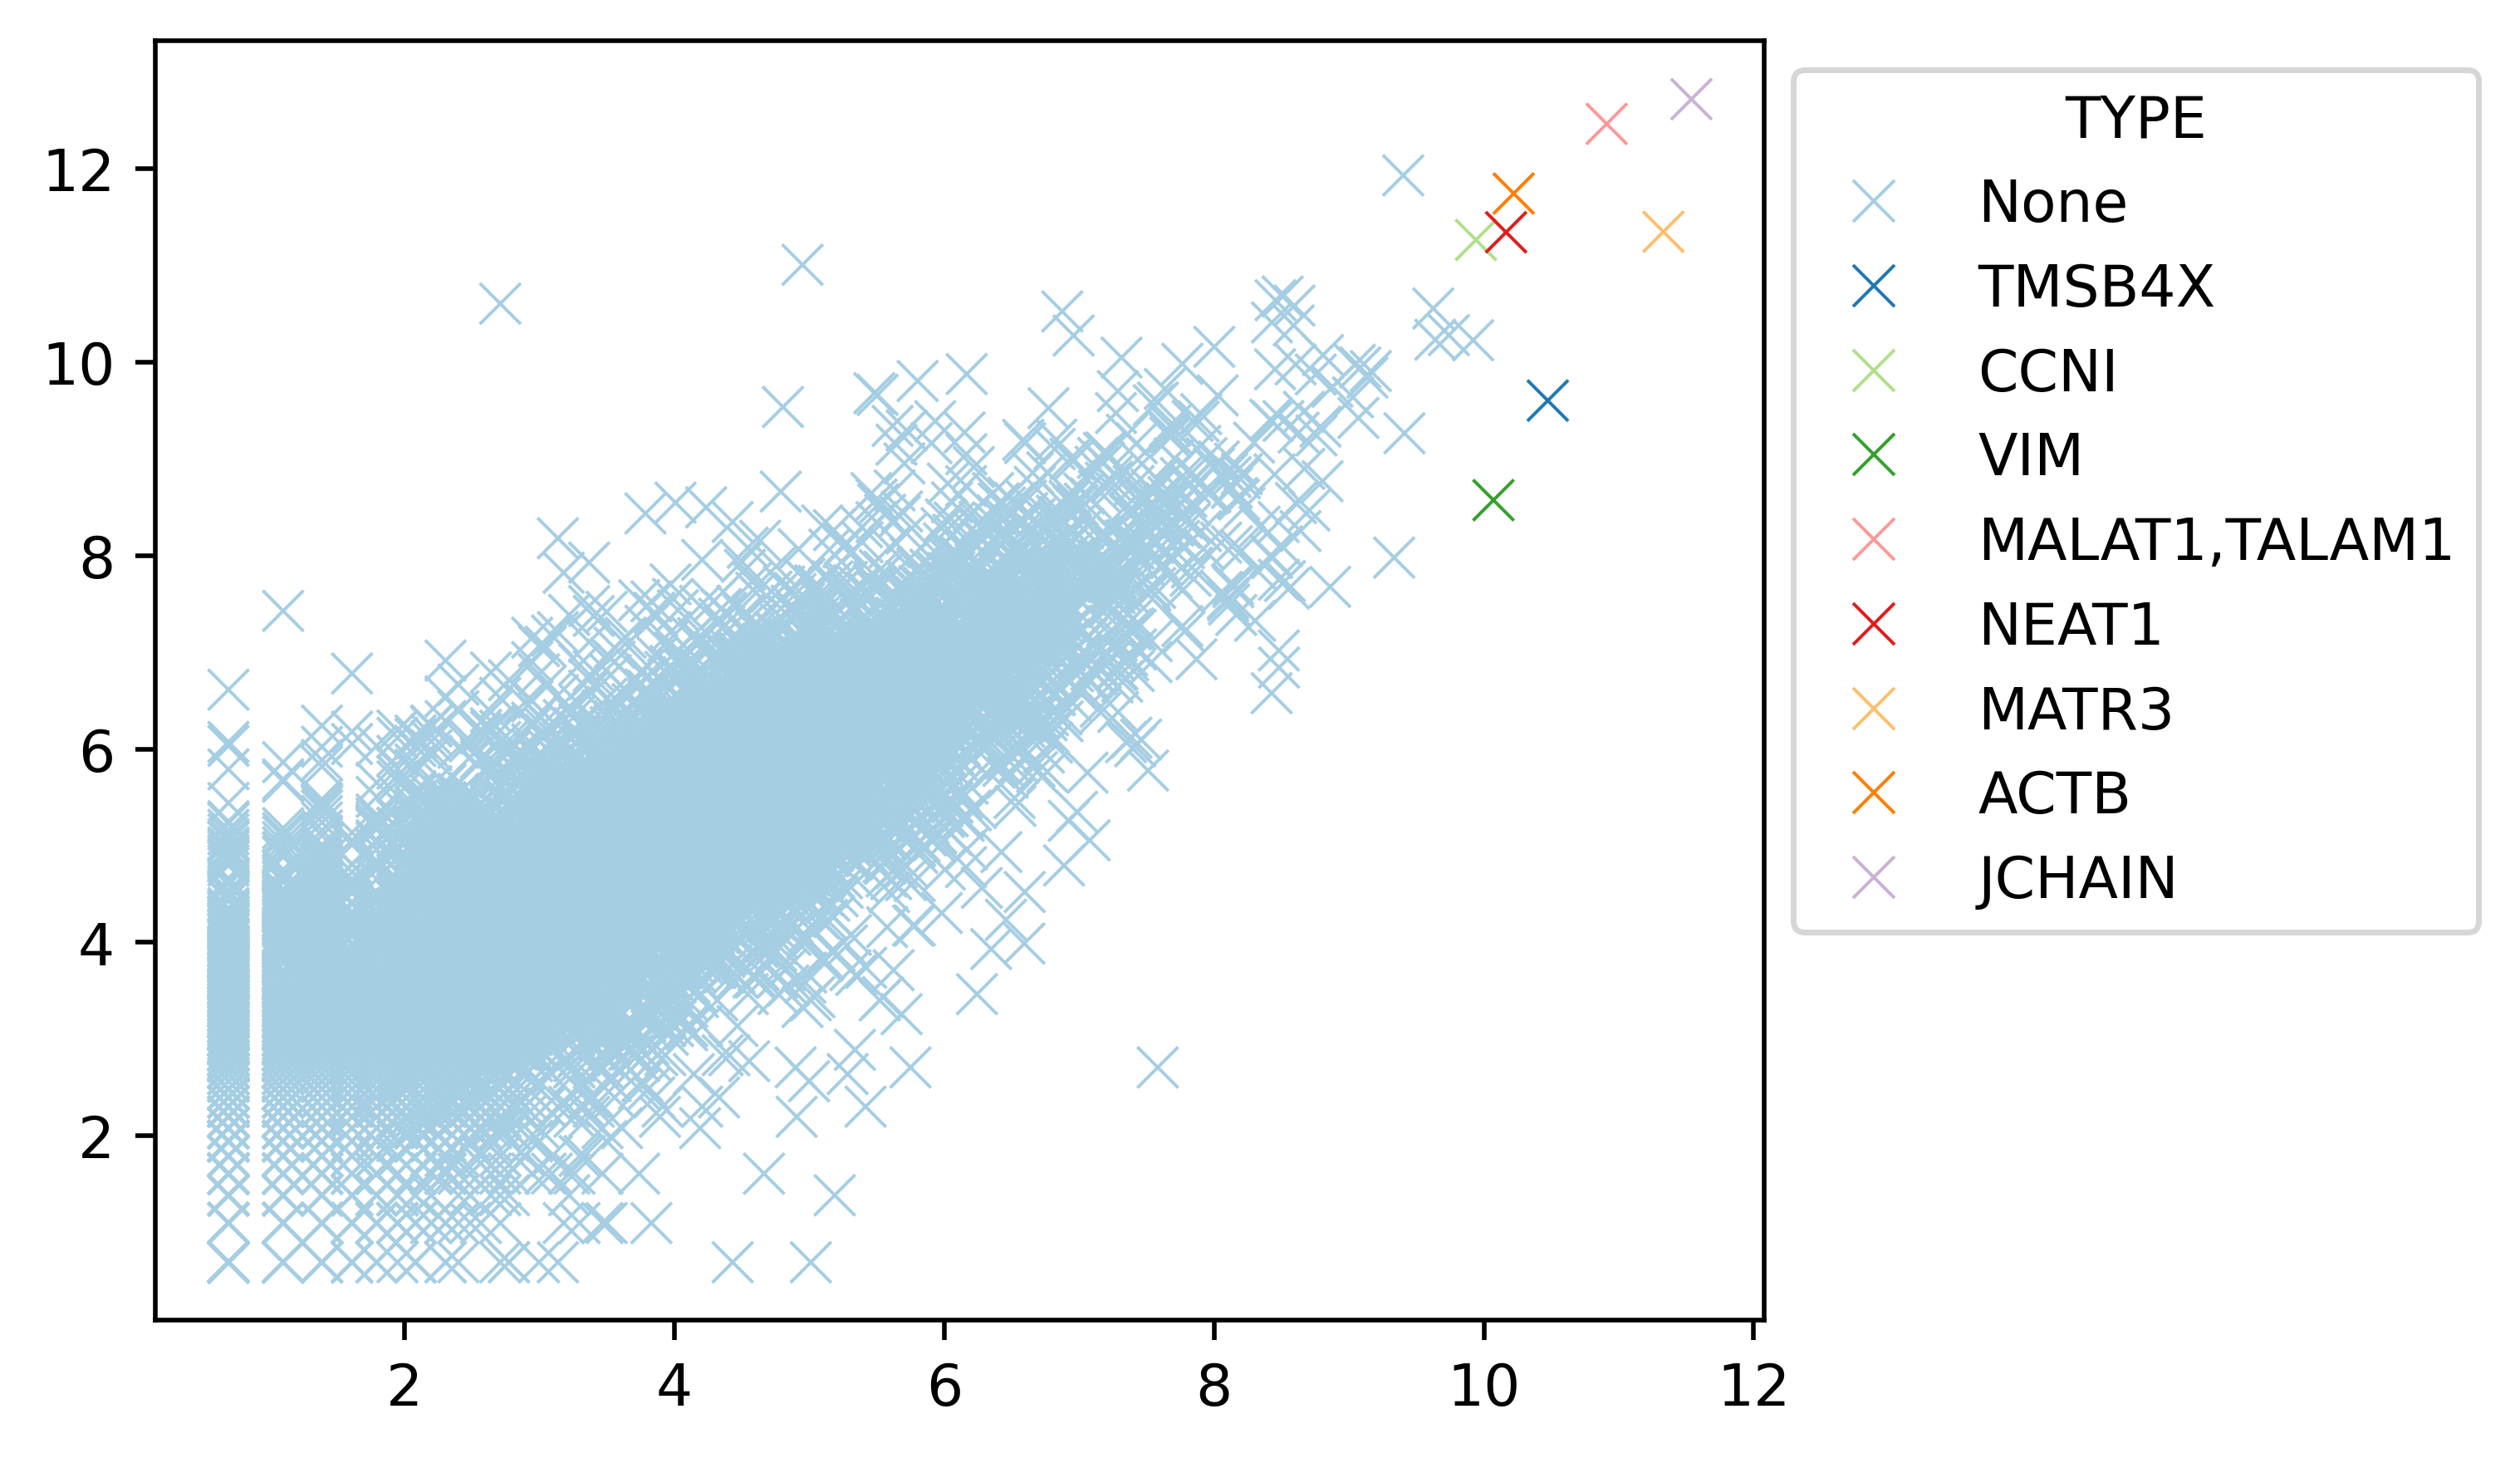

In [287]:
plt.figure(figsize=(5, 4), dpi=500)
list_t = list() 

for gene in GeneCountsAcrossDatasets['gene']:
    if gene == 'JCHAIN':
        list_t.append('JCHAIN')
    elif gene == 'MATR3':
        list_t.append('MATR3')
    elif gene == 'MALAT1,TALAM1':
        list_t.append('MALAT1,TALAM1')
    elif gene == 'TMSB4X':
        list_t.append('TMSB4X')
    elif gene == 'ACTB':
        list_t.append('ACTB')
    elif gene == 'NEAT1':
        list_t.append('NEAT1')
    elif gene == 'VIM':
        list_t.append('VIM')
    elif gene == 'CCNI':
        list_t.append('CCNI')
    else:
        list_t.append('None')
GeneCountsAcrossDatasets['TYPE'] = list_t
    
ax1 = sns.scatterplot(data=GeneCountsAcrossDatasets, alpha=1, marker='x', 
                      s=50, 
                # color='black',
                hue='TYPE', legend=True, palette='Paired',
            x='Joanito', y='Chen',)

ax1.set_xlabel('');
ax1.set_ylabel('');
sns.move_legend(ax1, "upper left", bbox_to_anchor=(1, 1))

# ax1.set_xticklabels([]);
# ax1.set_yticklabels([]);
# fig.tight_layout();

## Inspect cell-type count for top 8 MS-encoding genes

In [6]:
joanito_nanomnt = pd.read_csv('/node200data/18parkky/datasets/data/public/processed_data/Joanito_et_al/NanoMnT.AlleleTable.gene_labeled.tsv.gz', sep='\t')
# joanito_nanomnt = pd.read_csv('/node200data/18parkky/datasets/data/public/processed_data/Joanito_et_al/NanoMnT.AlleleTable.gene_labeled.tsv.gz', sep='\t')

In [4]:
import glob
import scanpy as sc 

def saveWithPickle(obj, PATH_out, filename="saveWithPickle"):
    import pickle
    with open(f'{PATH_out}/{filename}.pickle', 'wb') as handle:
        pickle.dump(obj, handle, protocol=pickle.HIGHEST_PROTOCOL)

def loadFromPickle(dir_pickle):
    import pickle
    with open(dir_pickle, 'rb') as handle:
        unserialized_pickle = pickle.load(handle)
    return unserialized_pickle

In [40]:
len('TCCTGTTGGG')

10

In [29]:
import h5py
import numpy as np
import scipy.sparse as sp
import anndata as ad


with h5py.File("/node200data/18parkky/datasets/data/public/processed_data/Joanito_et_al/CRC-SG1/cellranger/XHC137/outs/molecule_info.h5", "r") as f:
    barcodes = np.array(f["barcodes"]).astype(str)  # List of barcodes
    genes = np.array(f["features/name"]).astype(str)  # Gene names
    umi_values = np.array(f["umi"])  # UMI sequences
    barcode_idx = np.array(f["barcode_idx"])  # Barcode indices
    feature_idx = np.array(f["feature_idx"])  # Gene indices

def find_gene_for_umi_cb(query_cb, query_umi):
    # Get the barcode index
    cb_index = np.where(barcodes == query_cb)[0]
    if len(cb_index) == 0:
        return None  # Cell barcode not found
    cb_index = cb_index[0]  # Convert to integer

    # Find the molecule with matching CB and UMI
    matches = np.where((barcode_idx == cb_index) & (umi_values == query_umi))[0]
    if len(matches) == 0:
        return None  # No matching UMI

    # Get the corresponding gene(s)
    assigned_genes = genes[feature_idx[matches]]
    return list(set(assigned_genes))  # Unique gene names

# query_cb = "AAACCCGGTTTG"  # Replace with your actual CB
# query_umi = 12345678  # Replace with your actual UMI (integer)

# assigned_gene = find_gene_for_umi_cb(query_cb, query_umi)
# print("Assigned gene(s):", assigned_gene)


In [56]:
feature_idx

array([  565,  1432,  2066, ..., 32410, 28904, 20003], dtype=uint32)

In [48]:
def umi_to_integer(umi_str):
    """Convert a nucleotide UMI to its integer representation."""
    base4_map = {'A': 0, 'C': 1, 'G': 2, 'T': 3}
    umi_int = 0
    for nucleotide in umi_str:
        umi_int = (umi_int << 2) | base4_map[nucleotide]  # Shift left by 2 bits (base 4)
    return umi_int

def integer_to_umi(umi_int, umi_length):
    """Convert an integer back to a UMI nucleotide sequence."""
    base4_map = ['A', 'C', 'G', 'T']
    umi_str = []

    for _ in range(umi_length):
        umi_str.append(base4_map[umi_int & 3])  # Get the last 2 bits (base-4 digit)
        umi_int >>= 2  # Shift right by 2 bits to process the next nucleotide

    return "".join(umi_str[::-1])  # Reverse to get the correct order

In [52]:
integer_to_umi(149025, 10)

'AGCACGAGAC'

In [46]:
umi_to_integer('AGCACGAGAC')

149025

In [70]:
UMI_oi  = 'CGACTGTTTT'
CB_oi   = 'GATCGTATCCTTGACC'
UMI_oi_integer = umi_to_integer(UMI_oi)
print(UMI_oi_integer)
for idx, entry in enumerate(umi_values):
    if entry == UMI_oi_integer:
        if CB_oi == barcodes[barcode_idx[idx]]: 
            print(idx, barcodes[barcode_idx[idx]], genes[feature_idx[idx]])
        else:
            print('\t', idx, barcodes[barcode_idx[idx]], genes[feature_idx[idx]])

401151
	 1373942 ACGAGGATCTCGTATT RTN3
	 1417984 ACGCAGCAGAATTCCC HSP90AB1
	 1964127 ACTTTCACACGAGAGT TFF3
	 2735216 AGTGAGGAGTGTTAGA MTRNR2L12
	 2900936 AGTTGGTTCCCATTAT JAK1
	 3237375 ATCGAGTGTACTTAGC RPL34
	 3293404 ATCTGCCAGTCAATAG RPL8
	 4312963 CAGAGAGCACTTAACG OAZ1
	 4340641 CAGATCACAACGATGG ELP6
	 7127018 CTAATGGTCCTTGACC IGKV1-8
	 7620160 CTCGGGAAGAGTCGGT TPM2
	 8784984 GACGGCTAGCACGCCT SPINK4
	 8891136 GACTACAAGACCCACC RPS18
	 9398974 GCAAACTGTCTTCTCG IGHV3-20
	 11100307 GTACGTATCACTCTTA RPS12
	 11408803 GTCGGGTGTATGAAAC CGRRF1
	 11687413 GTGCTTCAGCAGCCTC CTSB
	 11857643 GTGTTAGGTACGCACC BCAP29
	 13155459 TCGTACCAGGCGATAC SNX27
	 13794139 TGCACCTCAAGCCATT PNN
	 14999239 TTGCGTCTCGGCGGTT MT-ATP6
	 15200885 TTTCCTCTCTCTAAGG CORO1C


In [95]:
joanito_nanomnt[(joanito_nanomnt['gene']=='MATR3')].head(2)[['read_name', 'flag', 'CB', 'UMI', 'SampleID', 'gene']]

,read_name,flag,CB,UMI,SampleID,gene
3171,K00250:342:H3HTNBBXY:5:2205:21369:9965,16,GATCGTATCCTTGACC-1,CGACTGTTTT,XHC137,MATR3
3172,K00250:342:H3HTNBBXY:5:1108:22384:35673,16,CGGACACGTCCGTGAC-1,AACATCCAGC,XHC137,MATR3


In [ ]:
# AAAATCGGCCTC

### Load adata and label cell-type information

In [ ]:
# adata_J = sc.read_h5ad('/node200data/18parkky/datasets/data/public/processed_data/Joanito_et_al/2_cell_type_labeled_h5ad/Joanito.preprocessed.NanoMnT.ManualAnnot.h5ad')
# adata_C = sc.read_h5ad('/node200data/18parkky/datasets/data/public/processed_data/Immunotherapy_CRC_Chen_et_al/2_cell_type_labeled_h5ad/Chen.MSI.preprocessed.NanoMnT.ManualAnnot.h5ad')

In [71]:
adata_C      = sc.read_h5ad('/node200data/18parkky/datasets/data/public/processed_data/Immunotherapy_CRC_Chen_et_al/2_cell_type_labeled_h5ad/Chen.MSI.preprocessed.NanoMnT.ManualAnnot.MSI_score_labeled.h5ad')
adata_J   = sc.read_h5ad('/node200data/18parkky/datasets/data/public/processed_data/Joanito_et_al/2_cell_type_labeled_h5ad/Joanito.MSI.preprocessed.NanoMnT.ManualAnnot.MSI_score_labeled.h5ad')

In [11]:
dict_Identifier_to_lvl1CellType_J = dict() 
dict_Identifier_to_lvl2CellType_J = dict() 

for PATH_pkl in glob.glob(f'/node200data/18parkky/datasets/data/public/processed_data/Joanito_et_al/2_cell_type_labeled_h5ad/dict_Identifier_to_CellType/*.lvl1.pickle'):
    temp_pkl = loadFromPickle(PATH_pkl)
    for k, v in temp_pkl.items(): dict_Identifier_to_lvl1CellType_J[k] = v
    
for PATH_pkl in glob.glob(f'/node200data/18parkky/datasets/data/public/processed_data/Joanito_et_al/2_cell_type_labeled_h5ad/dict_Identifier_to_CellType/*.lvl2.pickle'):
    temp_pkl = loadFromPickle(PATH_pkl)
    for k, v in temp_pkl.items(): dict_Identifier_to_lvl2CellType_J[k] = v

# Tumor cells
for tup in adata_J[~adata_J.obs['Identifier'].isin(dict_Identifier_to_lvl1CellType_J.keys())].obs.itertuples():
    dict_Identifier_to_lvl1CellType_J[tup.Identifier] = tup.Manual_CellType_lvl_1
    dict_Identifier_to_lvl2CellType_J[tup.Identifier] = 'Tumor epithelial'

adata_J.obs['Manual_CellType_lvl_1'] = [ dict_Identifier_to_lvl1CellType_J[Identifier] for Identifier in adata_J.obs['Identifier'] ]
adata_J.obs['Manual_CellType_lvl_2'] = [ dict_Identifier_to_lvl2CellType_J[Identifier] for Identifier in adata_J.obs['Identifier'] ]

In [12]:
dict_Identifier_to_lvl1CellType_C = dict() 
dict_Identifier_to_lvl2CellType_C = dict() 

for PATH_pkl in glob.glob(f'/node200data/18parkky/datasets/data/public/processed_data/Immunotherapy_CRC_Chen_et_al/2_cell_type_labeled_h5ad/dict_Identifier_to_CellType/*.lvl1.pickle'):
    temp_pkl = loadFromPickle(PATH_pkl)
    for k, v in temp_pkl.items(): dict_Identifier_to_lvl1CellType_C[k] = v
    
for PATH_pkl in glob.glob(f'/node200data/18parkky/datasets/data/public/processed_data/Immunotherapy_CRC_Chen_et_al/2_cell_type_labeled_h5ad/dict_Identifier_to_CellType/*.lvl2.pickle'):
    temp_pkl = loadFromPickle(PATH_pkl)
    for k, v in temp_pkl.items(): dict_Identifier_to_lvl2CellType_C[k] = v

# Tumor cells
for tup in adata_C[~adata_C.obs['Identifier'].isin(dict_Identifier_to_lvl1CellType_C.keys())].obs.itertuples():
    dict_Identifier_to_lvl1CellType_C[tup.Identifier] = tup.Manual_CellType_lvl_1
    dict_Identifier_to_lvl2CellType_C[tup.Identifier] = 'Tumor epithelial'

adata_C.obs['Manual_CellType_lvl_1'] = [ dict_Identifier_to_lvl1CellType_C[Identifier] for Identifier in adata_C.obs['Identifier'] ]
adata_C.obs['Manual_CellType_lvl_2'] = [ dict_Identifier_to_lvl2CellType_C[Identifier] for Identifier in adata_C.obs['Identifier'] ]

In [ ]:
adata_C.obs['dataset'] = 'Chen et al'
adata_J.obs['dataset'] = 'Joanito et al'

In [18]:
adata_C.write('/node200data/18parkky/datasets/data/public/processed_data/Immunotherapy_CRC_Chen_et_al/2_cell_type_labeled_h5ad/Chen.MSI.preprocessed.NanoMnT.ManualAnnot.labeled.h5ad')
adata_J.write('/node200data/18parkky/datasets/data/public/processed_data/Joanito_et_al/2_cell_type_labeled_h5ad/Joanito.MSI.preprocessed.NanoMnT.ManualAnnot.labeled.h5ad')

In [9]:
adata_C = sc.read_h5ad('/node200data/18parkky/datasets/data/public/processed_data/Immunotherapy_CRC_Chen_et_al/2_cell_type_labeled_h5ad/Chen.MSI.preprocessed.NanoMnT.ManualAnnot.labeled.h5ad')
adata_J = sc.read_h5ad('/node200data/18parkky/datasets/data/public/processed_data/Joanito_et_al/2_cell_type_labeled_h5ad/Joanito.MSI.preprocessed.NanoMnT.ManualAnnot.labeled.h5ad')

In [39]:
adata_J.obs.columns

Index(['doublet_score', 'predicted_doublet', 'SampleID', 'PatientID',
       'BiopsySite', 'n_genes_by_counts', 'log1p_n_genes_by_counts',
       'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes',
       'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes',
       'pct_counts_in_top_500_genes', 'total_counts_mt',
       'log1p_total_counts_mt', 'pct_counts_mt', 'Identifier',
       'Author_CellType_lvl_1', 'Author_CellType_lvl_2', 'n_genes', 'leiden',
       'AvgSTRDiff', 'StdSTRDiff', 'NumSTRLoci', 'MSI',
       'Manual_CellType_lvl_1', 'Manual_CellType_lvl_2'],
      dtype='object')

<Axes: xlabel='total_counts', ylabel='Manual_CellType_lvl_1'>

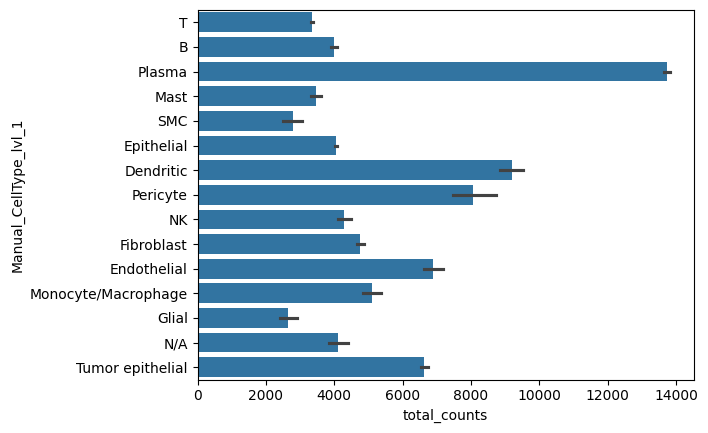

In [60]:
sns.barplot(data=adata_C.obs, y='Manual_CellType_lvl_1', x='total_counts')

In [72]:
adata_C = adata_C.raw.to_adata()
sc.pp.normalize_total(adata_C)
sc.pp.log1p(adata_C)

In [76]:
adata_C = adata_C[(adata_C.obs['Manual_CellType_lvl_1'].isin( ['Tumor epithelial', 'Normal epithelial'] ))].copy()

In [77]:
sc.tl.rank_genes_groups(adata_C, groupby='Manual_CellType_lvl_1', method='wilcoxon')

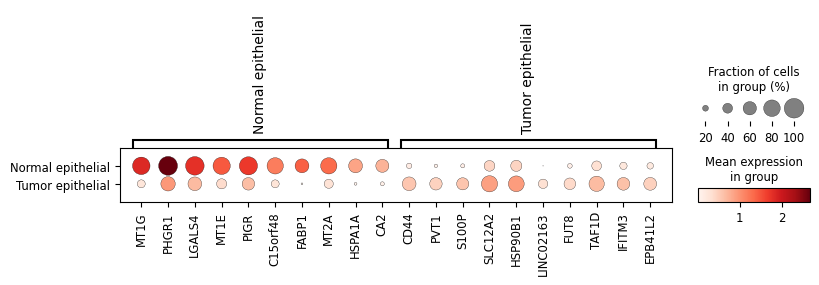

In [78]:
sc.pl.rank_genes_groups_dotplot(adata_C, groupby='Manual_CellType_lvl_1', n_genes=10)

In [58]:
l = list()
for PatientID, edf in adata_C.obs.groupby('PatientID'):
    print(PatientID)
    totalCounts = np.sum(edf['total_counts'])
    for Manual_CellType_lvl_1, edf2 in edf.groupby('Manual_CellType_lvl_1'):
        if Manual_CellType_lvl_1 in ['Plasma']:
            TumorReadPercentage = 100*np.sum(edf2['total_counts'])/totalCounts
            print(f'\t{Manual_CellType_lvl_1}\t{round( TumorReadPercentage , 2)}')
            l.append( TumorReadPercentage )
np.mean(l), np.std(l)

P04
	Plasma	32.81
P15
	Plasma	28.48
P17
	Plasma	38.11
P18
	Plasma	24.17
P19
	Plasma	39.74
P20
	Plasma	52.84
P21
	Plasma	37.27
P22
	Plasma	53.2
P23
	Plasma	36.21
P26
	Plasma	24.17


/tmp/ipykernel_112782/451755108.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for PatientID, edf in adata_C.obs.groupby('PatientID'):


(36.69812763962669, 9.701917408474156)

In [56]:
l = list()
for PatientID, edf in adata_J.obs.groupby('PatientID'):
    print(PatientID)
    totalCounts = np.sum(edf['total_counts'])
    for Manual_CellType_lvl_1, edf2 in edf.groupby('Manual_CellType_lvl_1'):
        if Manual_CellType_lvl_1 in ['Monocyte/Macrophage',]:
            TumorReadPercentage = 100*np.sum(edf2['total_counts'])/totalCounts
            print(f'\t{Manual_CellType_lvl_1}\t{round( TumorReadPercentage , 2)}')
            l.append( TumorReadPercentage )
            
np.mean(l), np.std(l)

CRC2783
	Monocyte/Macrophage	14.05
CRC2786
	Monocyte/Macrophage	11.77
CRC2787
	Monocyte/Macrophage	6.94
CRC2801
	Monocyte/Macrophage	9.92
CRC2817
	Monocyte/Macrophage	27.48
CRC2821
	Monocyte/Macrophage	12.81
SC035
	Monocyte/Macrophage	6.68
SC040
	Monocyte/Macrophage	8.81
SC041
	Monocyte/Macrophage	24.32
SC044
	Monocyte/Macrophage	7.76


/tmp/ipykernel_112782/106580751.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for PatientID, edf in adata_J.obs.groupby('PatientID'):


(13.055061884878706, 6.86865504873503)

<Axes: xlabel='total_counts', ylabel='Manual_CellType_lvl_1'>

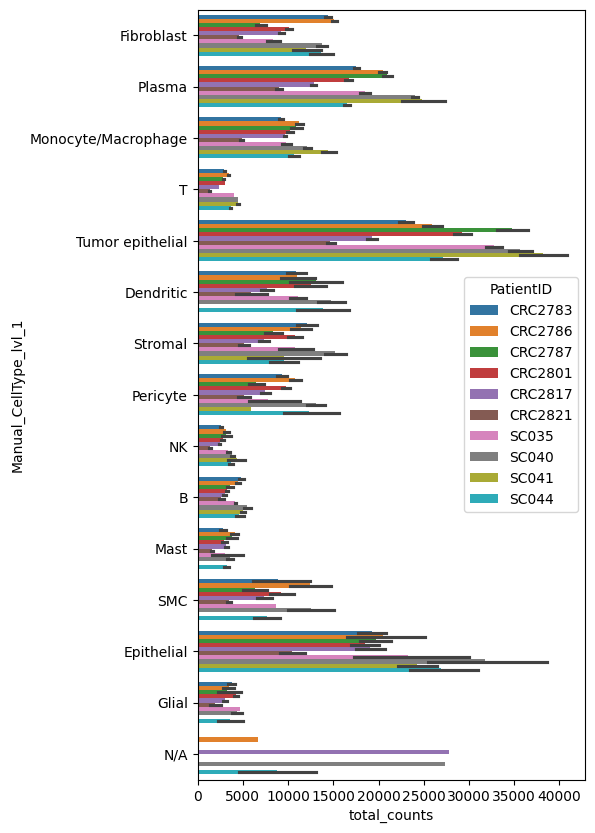

In [33]:
plt.figure(figsize=(5, 10))
sns.barplot(data=adata_J.obs, y='Manual_CellType_lvl_1', x='total_counts', hue='PatientID')

<Axes: xlabel='percent', ylabel='Manual_CellType_lvl_1'>

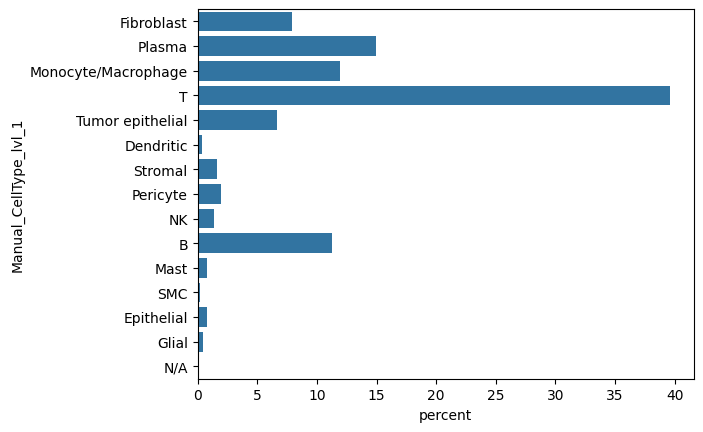

In [31]:
sns.countplot(data=adata_J.obs, y='Manual_CellType_lvl_1', stat='percent')

In [13]:
for Identifier in joanito_nanomnt['Identifier']:
    try: dict_Identifier_to_lvl1CellType_J[Identifier]
    except KeyError: dict_Identifier_to_lvl1CellType_J[Identifier]='N/A'
    
joanito_nanomnt['CellType_lvl_1'] = [ dict_Identifier_to_lvl1CellType_J[Identifier] for Identifier in joanito_nanomnt['Identifier'] ]

In [18]:
joanito_nanomnt_sc = joanito_nanomnt[(joanito_nanomnt['CellType_lvl_1']!='N/A')][['locus', 'allele', 'reference_STR_allele', 'CB', 'UMI', 'Identifier', 'gene', 'CellType_lvl_1']].copy()
joanito_nanomnt_sc

,locus,allele,reference_STR_allele,CB,UMI,Identifier,gene,CellType_lvl_1
4,chr11:63977928-63977944,TTTTTTTTTTTTTTTTT,17,GACGCGTCAATAGCAA-1,GGACCATCCC,XHC137-GACGCGTCAATAGCAA,intergenic,Monocyte/Macrophage
13,chr11:63977928-63977944,TTTTTTTTTTTTTTTTT,17,GACGCGTCAATAGCAA-1,GGACCATCCC,XHC137-GACGCGTCAATAGCAA,intergenic,Monocyte/Macrophage
14,chr11:63977928-63977944,TTTTTTTTTTTTTTTT,17,GACGCGTCAATAGCAA-1,GGACCATCCC,XHC137-GACGCGTCAATAGCAA,intergenic,Monocyte/Macrophage
17,chr11:64184532-64184543,AAAcAAAAAAAAA,12,CACAAACTCATCACCC-1,ACCCTGCCGC,XHC137-CACAAACTCATCACCC,ENSG00000288852,Monocyte/Macrophage
18,chr11:64184532-64184543,AAAcAAAAAAAAA,12,CACAAACTCATCACCC-1,ACCCTGCCGC,XHC137-CACAAACTCATCACCC,ENSG00000288852,Monocyte/Macrophage
...,...,...,...,...,...,...,...,...
4940095,chrY:7379646-7379656,AAAAAAAAAAA,11,GGTGTTAAGATGGCGT-1,CGGAATCGGA,EXT051-GGTGTTAAGATGGCGT,PRKY,T
4940096,chrY:7379646-7379656,AAAAAAAAAAA,11,TAGAGCTTCTCGGACG-1,TCGTTAAACA,EXT051-TAGAGCTTCTCGGACG,PRKY,T
4940097,chrY:7379646-7379656,AAAAAAAAAAAA,11,CAGCCGATCTTGACGA-1,ACAGAGCGTT,EXT051-CAGCCGATCTTGACGA,PRKY,T
4940098,chrY:7379646-7379656,AAAAAAAAAAA,11,AGTGAGGCAGGGTTAG-1,GATTCATTTG,EXT051-AGTGAGGCAGGGTTAG,PRKY,T


<Axes: xlabel='count', ylabel='CellType_lvl_1'>

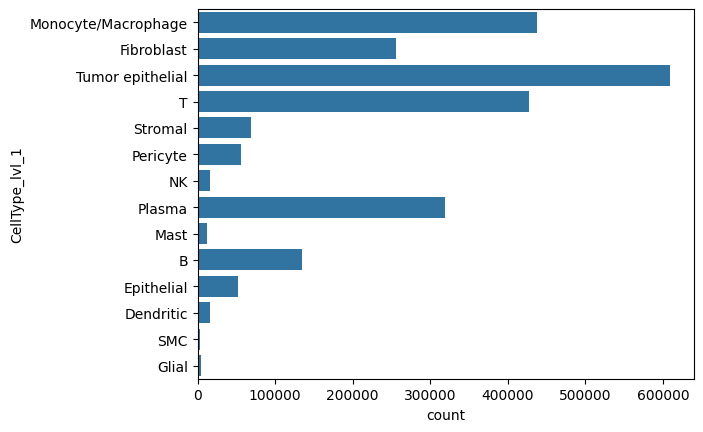

In [16]:
sns.countplot(data=joanito_nanomnt[(joanito_nanomnt['CellType_lvl_1']!='N/A')][['CellType_lvl_1']], y='CellType_lvl_1')

### Inspect cell-type proportion for top 8 genes

In [1]:
# MATR3
# MALAT1
# TMSB4X
# ACTB
# NEAT1
# VIM
# CCNI
top_genes = ['JCHAIN', 
             'MATR3', 
             'MALAT1', 
            #  'TALAM1',
             'TMSB4X', 
             'ACTB', 
             'NEAT1', 
             'VIM', 
             'CCNI']

In [75]:
adata_C_raw_var = adata_C.raw.to_adata().var.copy()
adata_J_raw_var = adata_J.raw.to_adata().var.copy()

In [334]:
joanito_nanomnt[(joanito_nanomnt['gene']=='MALAT1,TALAM1')]

,read_name,locus,repeat_unit,allele,reference_STR_allele,left_flanking_seq,right_flanking_seq,flag,CB,UMI,...,read_STR_allele,SampleID,flanking_quality,diff,Identifier,chrom,start,end,gene,n_gene
426,K00250:342:H3HTNBBXY:5:1222:8440:12779,chr11:65501009-65501020,T,TTTTTTTTTTTT,12,TGTGGG,ACACGA,16,GACGGCTCACACAGAG-1,AGCACGAGAC,...,12,XHC137,Good,0,XHC137-GACGGCTCACACAGAG,chr11,65501009,65501020,"MALAT1,TALAM1",2
427,K00250:342:H3HTNBBXY:5:1111:15676:34670,chr11:65501009-65501020,T,TTTTTTTTTT,12,TGTGGG,ACACGA,16,GACCTGGAGTCCTCCT-1,CTCTGCAGGG,...,10,XHC137,Good,-2,XHC137-GACCTGGAGTCCTCCT,chr11,65501009,65501020,"MALAT1,TALAM1",2
428,K00250:342:H3HTNBBXY:5:1101:20537:41686,chr11:65501009-65501020,T,TTTTTTTTTTT,12,TGTGGG,ACACGA,16,AGCGTATGTATAATGG-1,CCTTCTAGAC,...,11,XHC137,Good,-1,XHC137-AGCGTATGTATAATGG,chr11,65501009,65501020,"MALAT1,TALAM1",2
429,K00250:342:H3HTNBBXY:5:1217:26301:24278,chr11:65501009-65501020,T,TTTTTTTTTTTT,12,TGTGGG,ACACGA,0,CGCTTCAGTTGCTCCT-1,CCCATCCTTT,...,12,XHC137,Good,0,XHC137-CGCTTCAGTTGCTCCT,chr11,65501009,65501020,"MALAT1,TALAM1",2
430,K00250:342:H3HTNBBXY:5:1215:28168:48087,chr11:65501009-65501020,T,TTTTTTTTTTTT,12,TGTGGG,ACACGA,0,GAACATCTCAGTGCAT-1,CATCCCCGCT,...,12,XHC137,Good,0,XHC137-GAACATCTCAGTGCAT,chr11,65501009,65501020,"MALAT1,TALAM1",2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4887913,A00305:28:HCCYTDMXX:1:1224:16947:9768,chr11:65506098-65506110,A,AAAAAAAAAAAAA,13,TAGCTT,GCAAAA,16,GCCTCTAAGTTGTCGT-1,ATCAGCCAAA,...,13,EXT051,Good,0,EXT051-GCCTCTAAGTTGTCGT,chr11,65506098,65506110,"MALAT1,TALAM1",2
4887914,A00305:28:HCCYTDMXX:1:2235:15374:30185,chr11:65506098-65506110,A,AAAAAAAAAAA,13,TAGCTT,GCAAAA,16,CACATTTGTTAGAACA-1,GCCATCAGGG,...,11,EXT051,Good,-2,EXT051-CACATTTGTTAGAACA,chr11,65506098,65506110,"MALAT1,TALAM1",2
4887915,A00305:28:HCCYTDMXX:1:1371:14696:28009,chr11:65506098-65506110,A,AAAAAAAAAAAAA,13,TATCTT,GCAAAA,16,CTTCTCTTCAATACCG-1,TCATGCTCAC,...,13,EXT051,Good,0,EXT051-CTTCTCTTCAATACCG,chr11,65506098,65506110,"MALAT1,TALAM1",2
4887916,A00305:28:HCCYTDMXX:1:2159:9399:34648,chr11:65506098-65506110,A,AAAAAAAAAAAAAA,13,TAGCTT,GCAAAA,16,CACATAGGTCTGATCA-1,CTATCTATGG,...,14,EXT051,Good,1,EXT051-CACATAGGTCTGATCA,chr11,65506098,65506110,"MALAT1,TALAM1",2


In [4]:
import pandas as pd 
df = pd.read_csv('/node200data/18parkky/datasets/reference/transcriptome/GFF/gencode.v47.basic.annotation.labeled.gtf', sep='\t', nrows=10)
df.iloc[0].attributes

'gene_id "ENSG00000290825.2"; gene_type "lncRNA"; gene_name "DDX11L16"; level 2; tag "overlaps_pseudogene";'

In [339]:
adata_J.obs[(adata_J.obs['Identifier']=='XHC137-GACGGCTCACACAGAG')]

,doublet_score,predicted_doublet,SampleID,PatientID,BiopsySite,n_genes_by_counts,log1p_n_genes_by_counts,total_counts,log1p_total_counts,pct_counts_in_top_50_genes,...,n_genes,leiden,AvgSTRDiff,StdSTRDiff,NumSTRLoci,MSI,Manual_CellType_lvl_1,MSI_score,MSI_score_z,Manual_CellType_lvl_2
GACGGCTCACACAGAG-1,0.036232,False,XHC137,CRC2817,Core,2366,7.769379,9612.0,9.170872,38.72243,...,2366,2,-0.631579,1.563078,38,MSI-H,Monocyte/Macrophage,0.987207,0.282969,Monocyte


In [85]:
adata_concat = sc.concat([adata_C, adata_J])

/home/18parkky/anaconda3-2021.11/envs/sc/lib/python3.12/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
/home/18parkky/anaconda3-2021.11/envs/sc/lib/python3.12/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


In [87]:
adata_concat.obs['Author_CellType_lvl_1_DatasetLabeled'] = [ f'{tup.Author_CellType_lvl_1} - {tup.dataset[0]}' for tup in adata_concat.obs.itertuples() ]

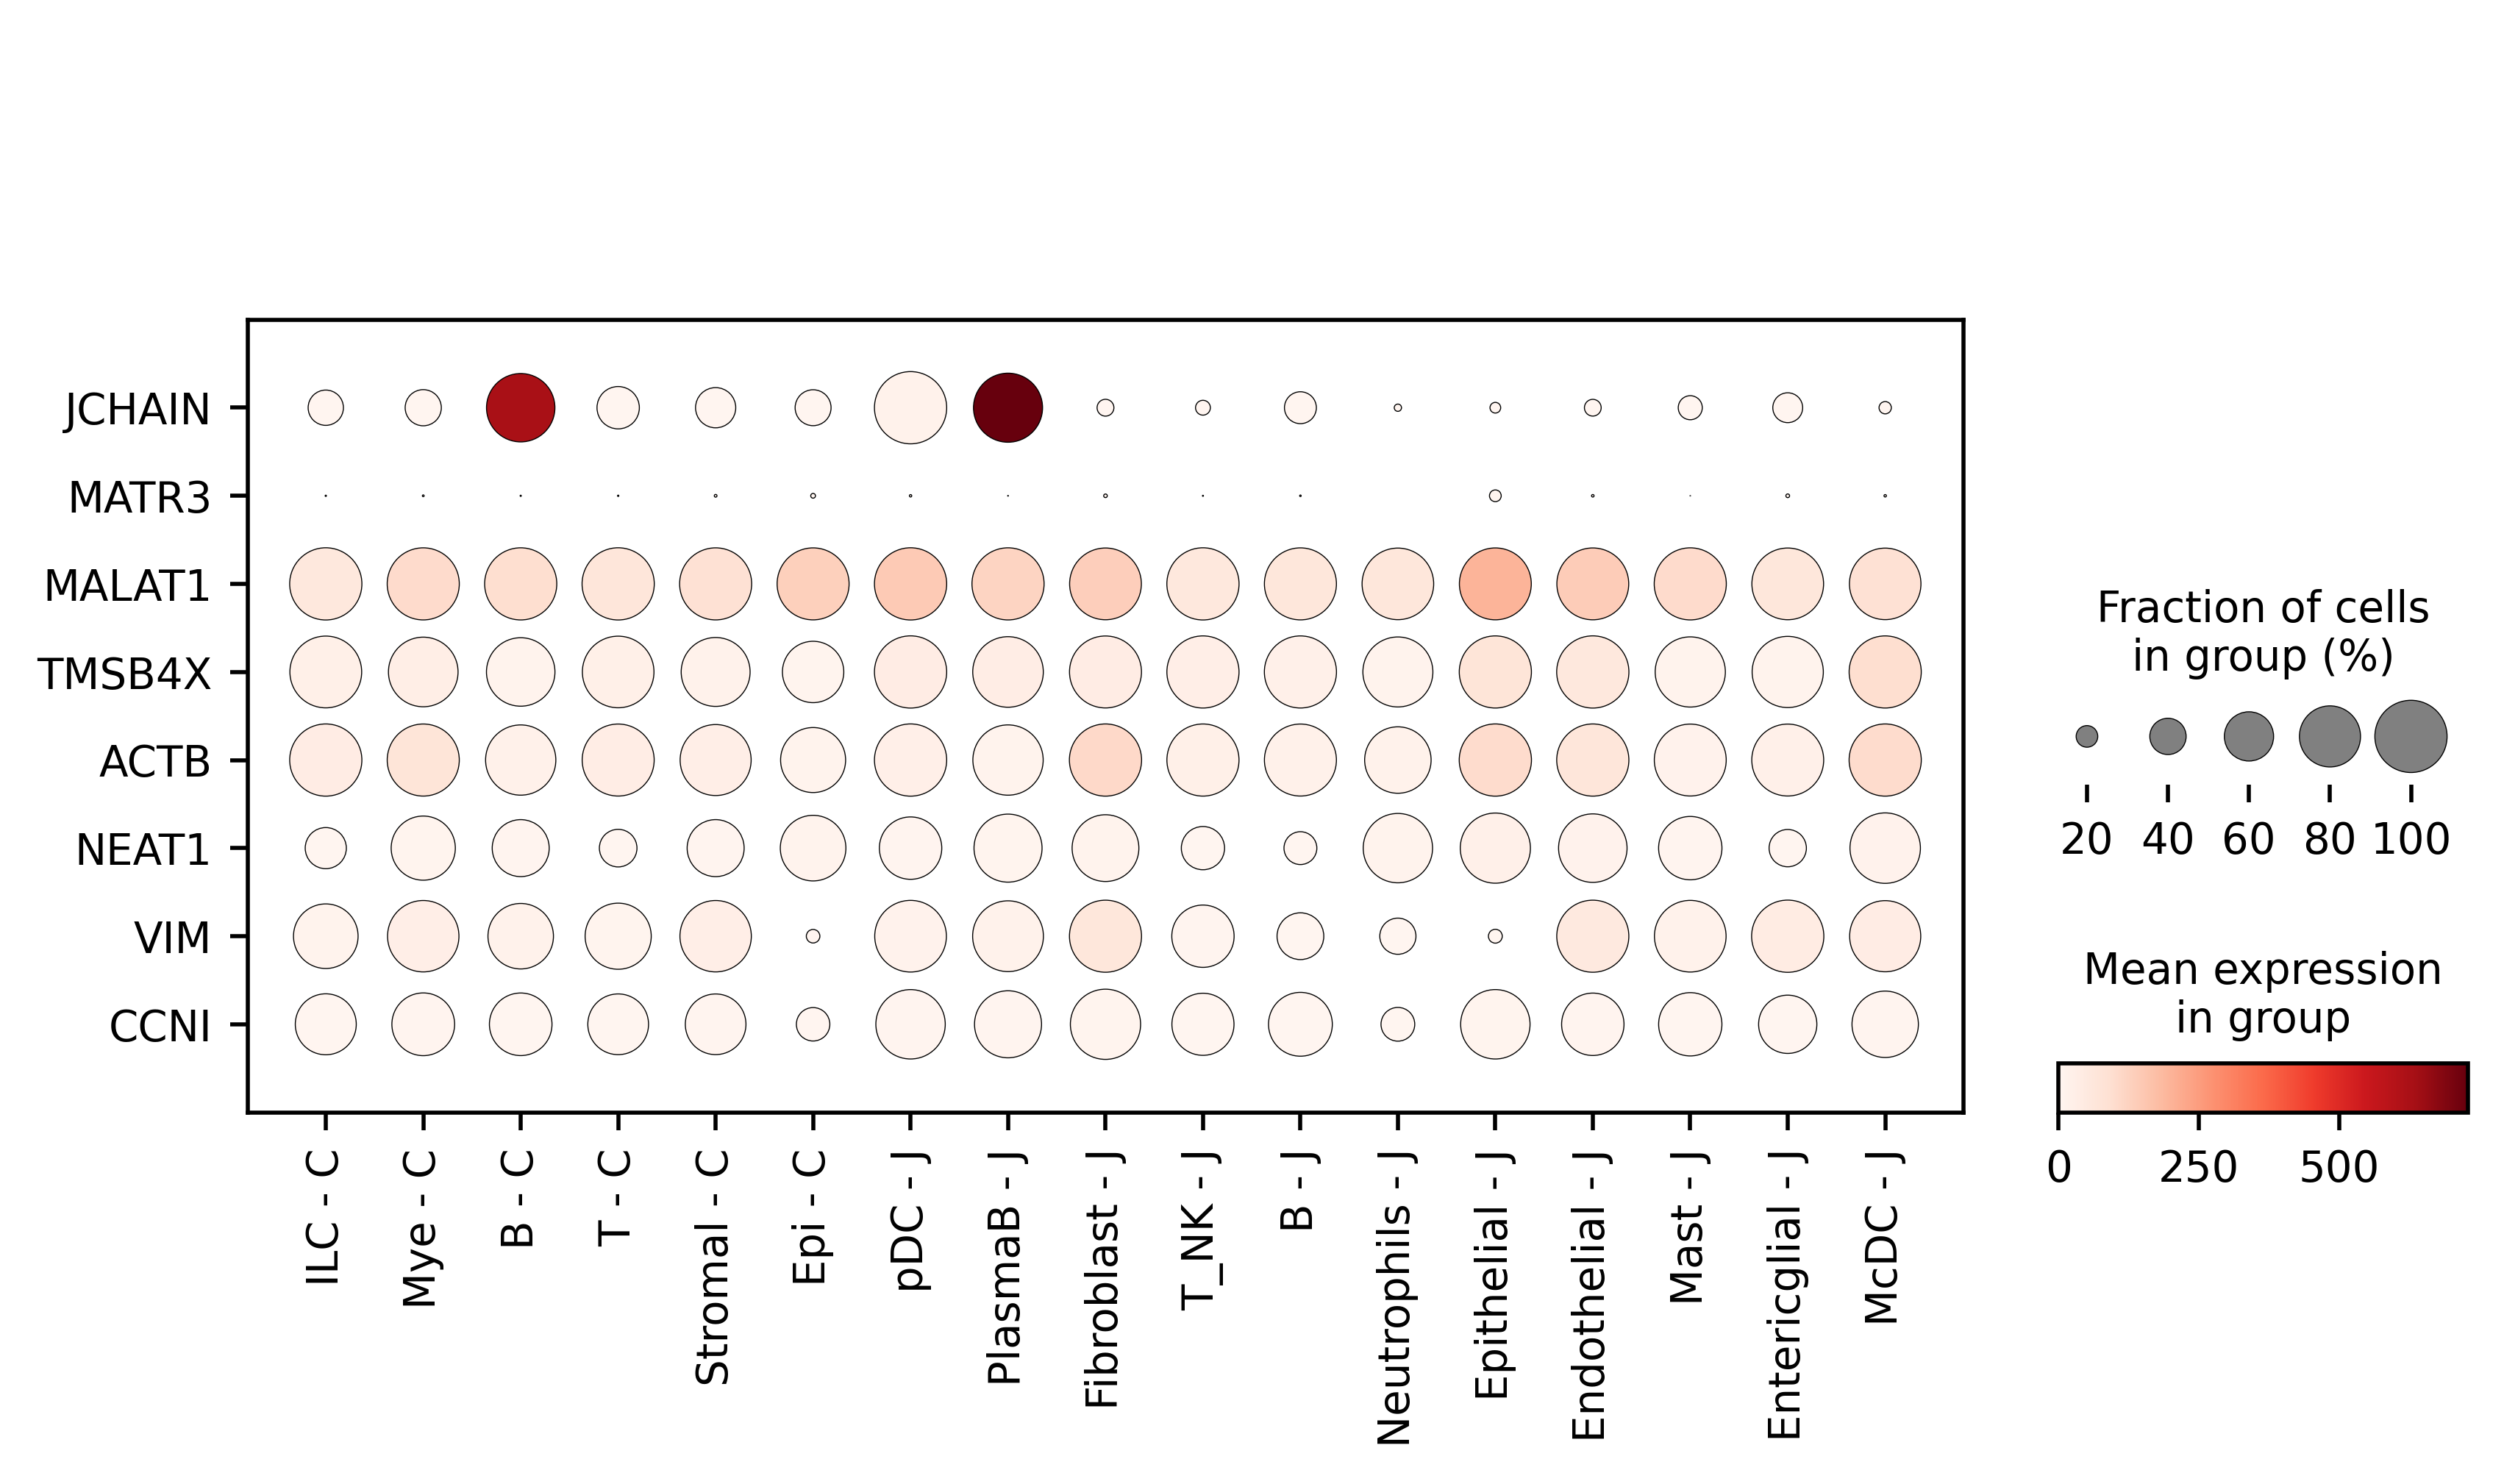

In [93]:
with plt.rc_context({"figure.dpi": (500), 'figure.figsize':(5, 4)},):
    sc.pl.dotplot(adata_concat, var_names=top_genes, 
                  groupby='Author_CellType_lvl_1_DatasetLabeled',
                  categories_order = [f'{CT} - C' for CT in set(adata_C.obs['Author_CellType_lvl_1'])] + [f'{CT} - J' for CT in set(adata_J.obs['Author_CellType_lvl_1'])],
                  swap_axes=True,
                  )

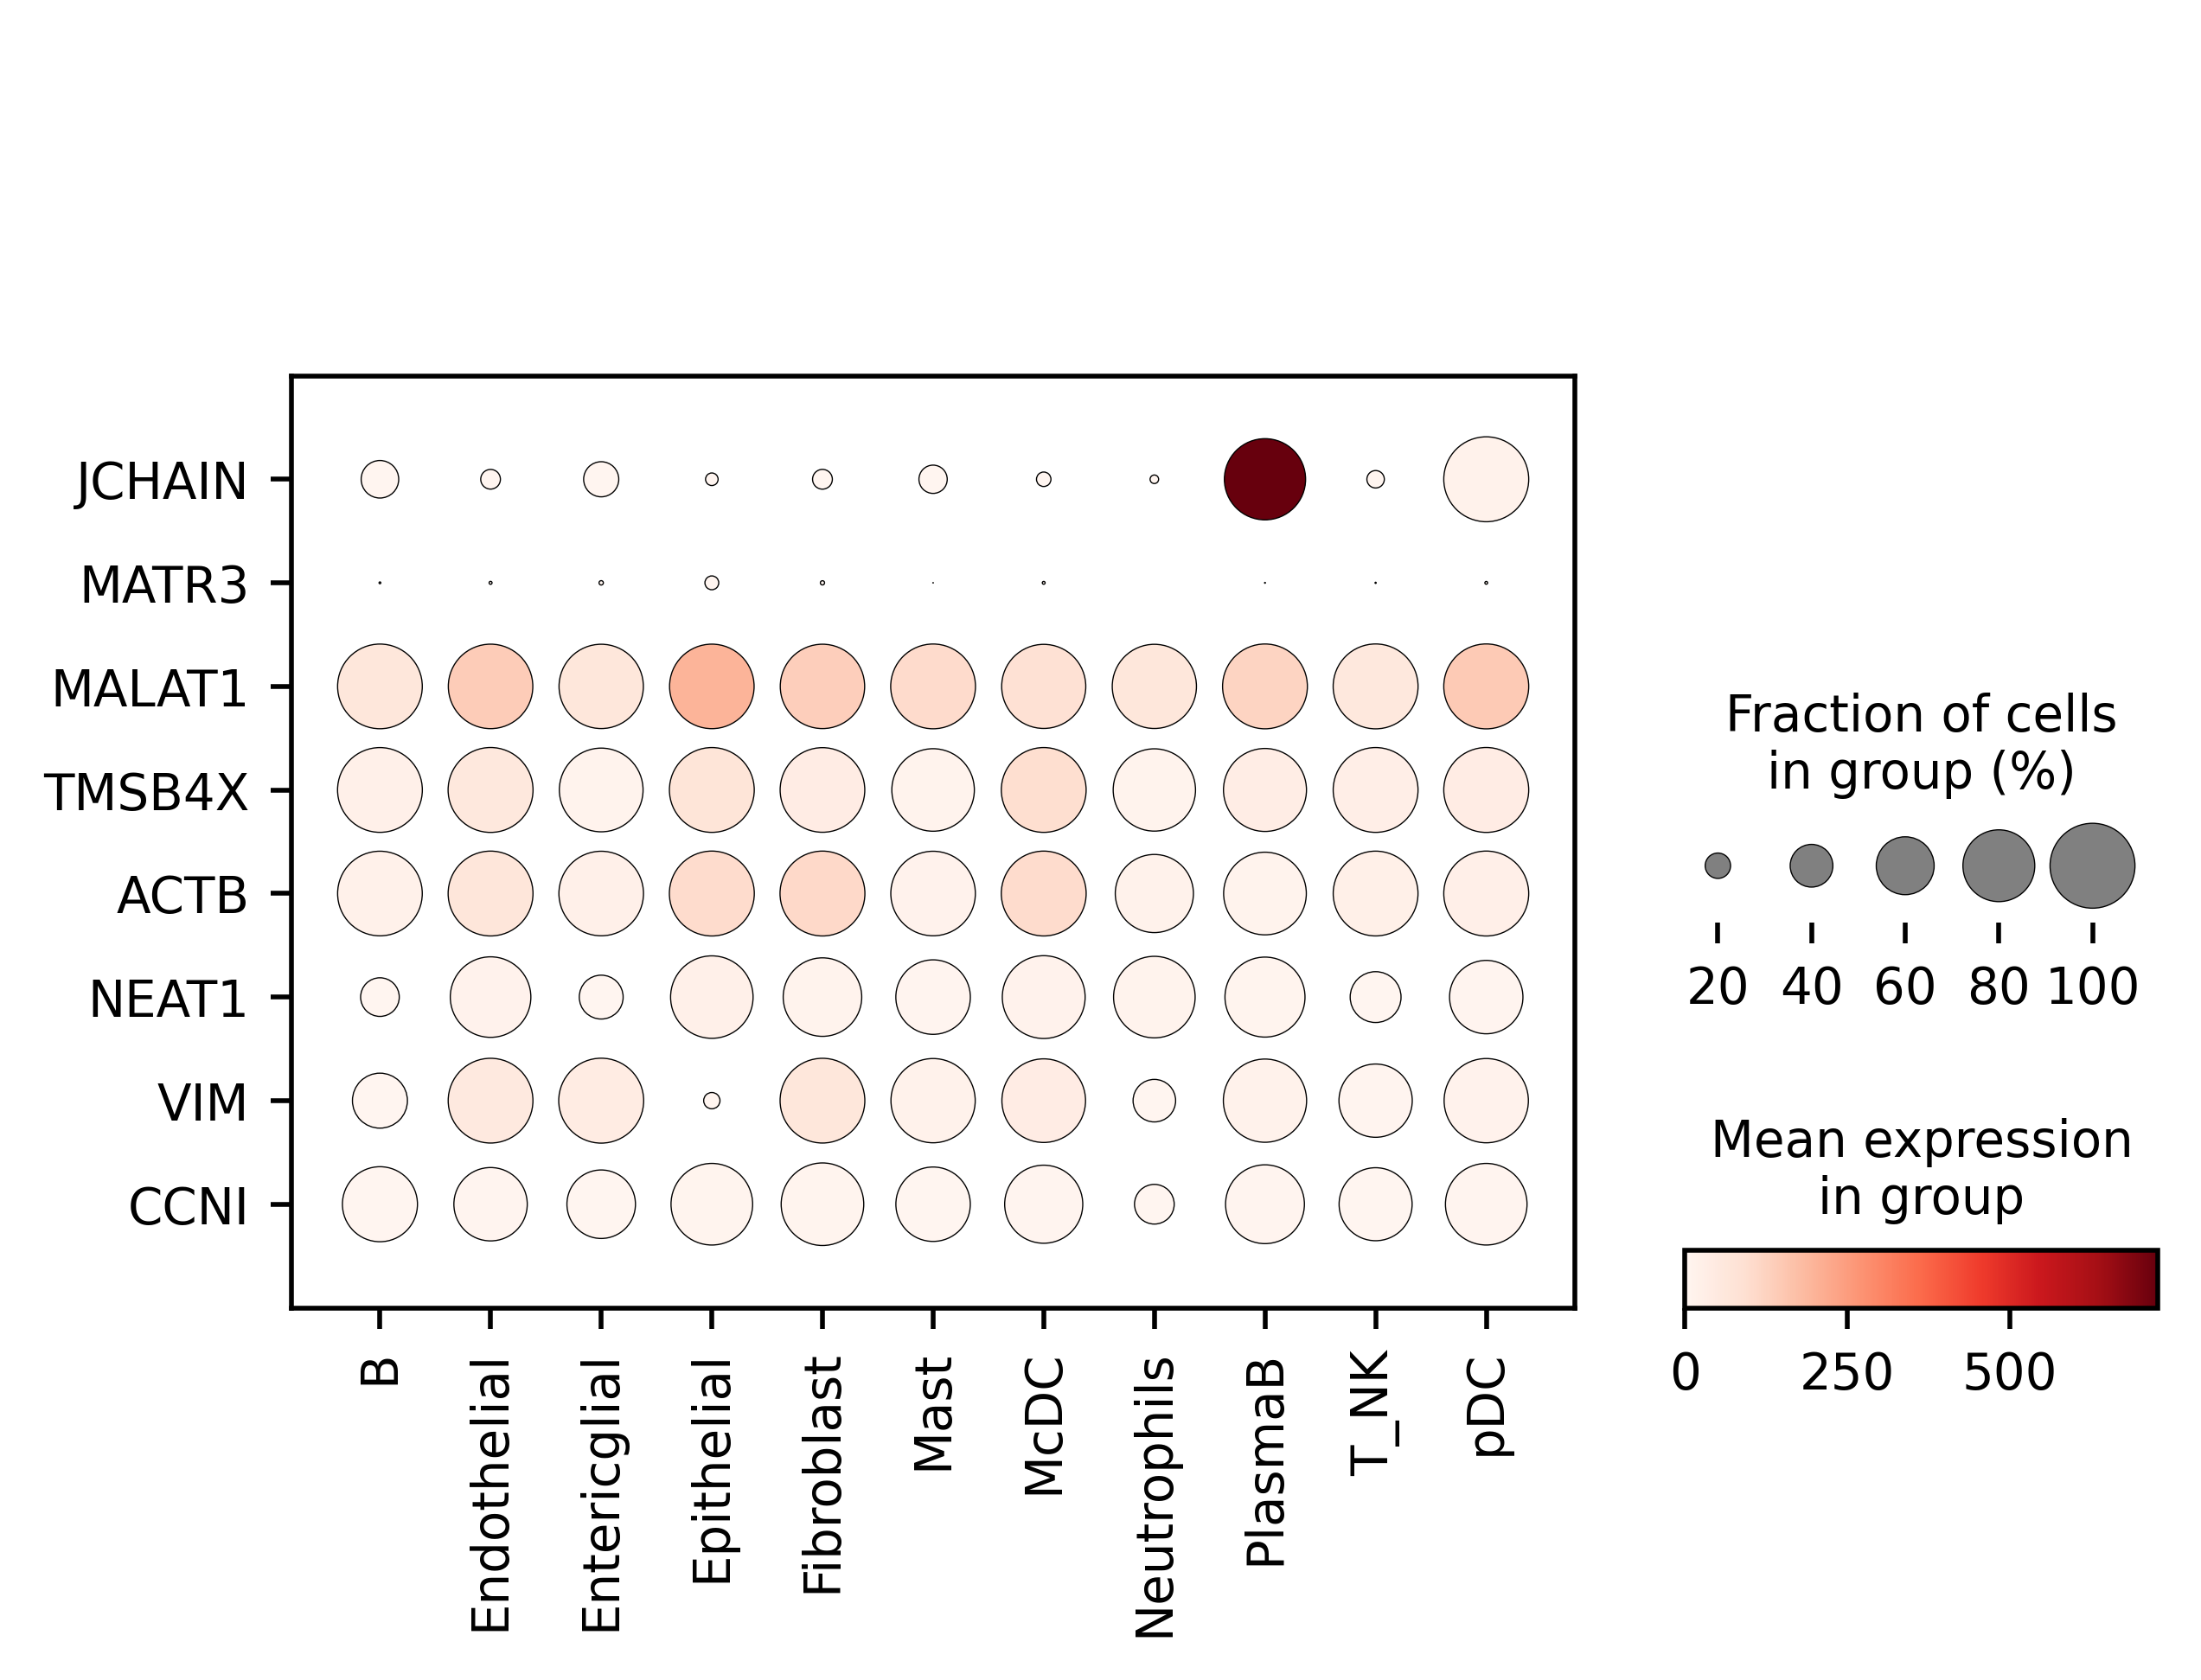

In [81]:
with plt.rc_context({"figure.dpi": (500), 'figure.figsize':(5, 4)},):
    sc.pl.dotplot(adata_J, var_names=top_genes, groupby='Author_CellType_lvl_1', swap_axes=True)